In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

from dateutil.relativedelta import relativedelta

2024-09-16 17:53:57.305705: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 17:53:57.308202: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 17:53:57.317381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 17:53:57.332687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 17:53:57.337302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 17:53:57.347816: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
import os
os.getcwd()

In [36]:
concat = pd.read_csv('../data/base_dataset_7.csv')
concat.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', 'target',
       'is_test', '주소', 'x', 'y', '계약년', '계약월', '거래취소여부', '거래일건물연식', '구', '동',
       '강남여부', '신축여부', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수'],
      dtype='object')

In [37]:
concat['계약날짜'] = concat['계약년'].astype(str) + ' ' + concat['계약월'].astype(str) + ' ' + concat['계약일'].astype(str)
# 따로 test데이터와 train 데이터 만듬
con = concat[concat['is_test'] == 0]
con.drop(columns='is_test', inplace=True)

# 계약날짜 컬럼을 datetime 형식으로 변환
con['계약날짜'] = pd.to_datetime(con['계약날짜'], format='%Y %m %d')

# 마지막 3개월 데이터만 필터링
date = pd.to_datetime('2023-04-01')
test = con[con['계약날짜'] >= date]
train = con[con['계약날짜'] < date]

# test데이터 정답파일 따로 빼둠
answer = test['target']
test.drop(columns='target', inplace=True)

train['is_test'] = 0
test['is_test'] = 1

con = pd.concat([train, test])

drop_col = ['번지', '본번', '부번', '아파트명', '계약일', '층', 'x', 'y', '강남여부', '신축여부', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수']

con.drop(columns=drop_col, inplace=True)

In [177]:
con['is_test'].value_counts()

0    1108190
1      10632
Name: is_test, dtype: int64

In [38]:
# 금리 데이터 로드 및 처리
interest = pd.read_csv('../data/한국기준금리07-23.csv')

interest['계약년월'] = interest['날짜'].astype(str).str[:6]

interest_grouped = interest.groupby('계약년월').agg({'기준금리': 'mean'}).reset_index()

con['계약월'] = con['계약월'].astype(str).str.zfill(2)
con['계약년월'] = con['계약년'].astype(str) + con['계약월'].astype(str)

con = pd.merge(con, interest_grouped, on='계약년월', how='left')

In [39]:
# 각 구별 가격변화율
con['제곱미터당가격'] = con['target'] / con['전용면적']

monthly_avg_price = con.groupby(['구', '계약년월'])['제곱미터당가격'].mean().reset_index()

monthly_avg_price.columns = ['구', '계약년월', '월별평균가']
monthly_avg_price['계약년월'] = pd.to_datetime(monthly_avg_price['계약년월'], format='%Y%m')

con['계약년월'] = pd.to_datetime(con['계약년월'], format='%Y%m')

monthly_avg_price['가격변화율'] = monthly_avg_price.groupby('구')['월별평균가'].pct_change()
monthly_avg_price['가격변화율'] = monthly_avg_price['가격변화율'].replace(0, np.nan)


con = pd.merge(con, monthly_avg_price, on=['구', '계약년월'], how='left')

In [40]:
con.sort_values(by='계약날짜', inplace=True)

con['이전거래가격'] = con.groupby(['주소', '전용면적'])['target'].shift(1)

# 주소와 전용면적으로 그룹화하고 계약날짜로 정렬
con = con.sort_values(by=['주소', '전용면적', '계약날짜'])

# 그룹별로 이전 거래일을 계산
con['이전거래일'] = con.groupby(['주소', '전용면적'])['계약날짜'].shift(1)

# 월 차이 계산: (현재 연도 * 12 + 현재 월) - (이전 연도 * 12 + 이전 월)
con['거래월차이'] = (con['계약날짜'].dt.year * 12 + con['계약날짜'].dt.month) - \
               (con['이전거래일'].dt.year * 12 + con['이전거래일'].dt.month)

con.sort_index(inplace=True)

In [41]:
con.loc[(con['가격변화율'].isnull()) & (con['target'].notnull()), '가격변화율'] = 0

In [182]:
con.columns

Index(['전용면적', '건축년도', 'target', '주소', '계약년', '계약월', '거래취소여부', '거래일건물연식', '구',
       '동', '계약날짜', 'is_test', '계약년월', '기준금리', '제곱미터당가격', '월별평균가', '가격변화율',
       '이전거래가격', '이전거래일', '거래월차이'],
      dtype='object')

In [42]:
# 필요없는 컬럼 드롭 & 기타 파생변수? 거래량, 이동평균 등

drop_col = ['건축년도', 'target',  '계약년', '계약월', '거래취소여부', '거래일건물연식', '계약년월']
con.drop(columns=drop_col, inplace=True, errors='ignore')


con['계약날짜'] = con['계약날짜'].astype(int)
con['이전거래일'] = con['이전거래일'].astype(int)

In [43]:
train = con.query('is_test==0')
test = con.query('is_test==1')

In [12]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in train.columns:
    if pd.api.types.is_numeric_dtype(train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약날짜', 'is_test', '기준금리', '제곱미터당가격', '월별평균가', '가격변화율', '이전거래가격', '이전거래일', '거래월차이']
범주형 변수: ['주소', '구', '동']


In [13]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(train[col].astype(str))
    train[col] = lbl.transform(train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    test[col] = lbl.transform(test[col].astype(str))

100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [71]:
# LSTM 모델 정의 함수
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# '계약날짜'로 정렬
df = train
df = df.sort_values(by=['구', '계약날짜'])

# 각 구별로 데이터 그룹화
for name, group in df.groupby('구'):
    print(f'Processing {name} data...')

    # 필요한 데이터 사용하여 LSTM 학습
    features_numeric = ['전용면적', '기준금리']  # 수치형 입력 변수 (가격변화율 제외)
    features_categorical = ['동']  # 범주형 변수
    target_variable = '가격변화율'  # 타겟 변수

    # 수치형 입력 변수 추출
    X_numeric = group[features_numeric]

    # 타겟 변수 추출
    y = group[target_variable].values.reshape(-1, 1)

    # 범주형 변수를 OneHotEncoder로 인코딩
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_categorical = encoder.fit_transform(group[features_categorical]) 

    # 수치형 입력 변수 정규화 (MinMaxScaler 사용)
    scaler_X = MinMaxScaler()
    X_numeric_scaled = scaler_X.fit_transform(X_numeric)

    # 타겟 변수 정규화 (별도의 MinMaxScaler 사용)
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    # 원핫 인코딩된 범주형 변수와 정규화된 수치형 입력 변수를 병합
    X_train = np.hstack([X_numeric_scaled, X_categorical])
    
    # 이후 시계열 데이터를 window_size로 만들어 LSTM 모델에 입력
    window_size = 3  # LSTM을 위한 시계열 길이
    X_lstm_train, y_lstm_train = [], []
    for i in range(window_size, len(X_train)):
        X_lstm_train.append(X_train[i-window_size:i])  # window_size 만큼의 데이터를 X로 사용
        y_lstm_train.append(y_scaled[i])  # 현재 시점의 타겟 변수 값을 y로 사용

    X_lstm_train = np.array(X_lstm_train)
    y_lstm_train = np.array(y_lstm_train)

    # LSTM 입력 형태로 변환 (samples, timesteps, features)
    X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], X_lstm_train.shape[1], X_train.shape[1]))

    # LSTM 모델 생성
    model = create_lstm_model((X_lstm_train.shape[1], X_lstm_train.shape[2]))

    # 모델 훈련
    model.fit(X_lstm_train, y_lstm_train, epochs=2, batch_size=1)

    # 모델 및 전처리 도구 저장 (구별로 저장)
    with open(f'./data/lstm_model_{name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    with open(f'./data/scaler_X_{name}.pkl', 'wb') as f:
        pickle.dump(scaler_X, f)
    
    with open(f'./data/scaler_y_{name}.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)
    
    with open(f'./data/encoder_{name}.pkl', 'wb') as f:
        pickle.dump(encoder, f)


Processing 강남구 data...
Epoch 1/2
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 52s 748us/step - loss: 0.0091
Epoch 2/2
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 52s 756us/step - loss: 0.0082
Processing 강동구 data...
Epoch 1/2
61196/61196 ━━━━━━━━━━━━━━━━━━━━ 46s 746us/step - loss: 0.0214
Epoch 2/2
61196/61196 ━━━━━━━━━━━━━━━━━━━━ 46s 748us/step - loss: 0.0201
Processing 강북구 data...
Epoch 1/2
21690/21690 ━━━━━━━━━━━━━━━━━━━━ 17s 759us/step - loss: 0.0088
Epoch 2/2
21690/21690 ━━━━━━━━━━━━━━━━━━━━ 16s 737us/step - loss: 0.0079
Processing 강서구 data...
Epoch 1/2
66047/66047 ━━━━━━━━━━━━━━━━━━━━ 49s 727us/step - loss: 0.0182
Epoch 2/2
66047/66047 ━━━━━━━━━━━━━━━━━━━━ 50s 760us/step - loss: 0.0160
Processing 관악구 data...
Epoch 1/2
35635/35635 ━━━━━━━━━━━━━━━━━━━━ 27s 738us/step - loss: 0.0124
Epoch 2/2
35635/35635 ━━━━━━━━━━━━━━━━━━━━ 27s 744us/step - loss: 0.0109
Processing 광진구 data...
Epoch 1/2
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 17s 763us/step - loss: 0.0158
Epoch 2/2
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 17s 756us/step -

In [106]:
# 테스트 데이터 예측
df_test = test.copy()  # 원본 데이터 보존
df_test['예측_가격변화율'] = np.nan  # 예측 결과를 저장할 열 생성

df_test['계약날짜'] = pd.to_datetime(df_test['계약날짜'], unit='ns')
df_test['이전거래일'] = pd.to_datetime(df_test['이전거래일'], unit='ns')


train['계약날짜'] = pd.to_datetime(train['계약날짜'], unit='ns')
train['이전거래일'] = pd.to_datetime(train['이전거래일'], unit='ns')
for name, group in df_test.groupby('구'):
    print(f'Predicting for {name} data...')
    
    # 그룹 내에서 인덱스 보존
    group_indices = group.index  # 원본 인덱스 저장

    # 필요한 데이터 사용하여 LSTM 예측 (학습 시 사용한 전처리 도구 로드)
    try:
        with open(f'./data/scaler_X_{name}.pkl', 'rb') as f:
            scaler_X = pickle.load(f)
        with open(f'./data/scaler_y_{name}.pkl', 'rb') as f:
            scaler_y = pickle.load(f)
        with open(f'./data/encoder_{name}.pkl', 'rb') as f:
            encoder = pickle.load(f)
        with open(f'./data/lstm_model_{name}.pkl', 'rb') as f:
            model = pickle.load(f)
    except FileNotFoundError:
        print(f"{name} 구에 대한 모델 또는 전처리 도구를 찾을 수 없습니다. 예측을 건너뜁니다.")
        continue

    features_numeric = ['전용면적', '기준금리']  # 수치형 입력 변수
    features_categorical = ['동']  # 범주형 변수

    # 수치형 입력 변수 추출
    X_numeric_test = group[features_numeric]

    # 결측치 처리 (필요한 경우)
    X_numeric_test = X_numeric_test.fillna(0)  # 또는 적절한 값으로 대체

    # 범주형 변수를 OneHotEncoder로 인코딩
    X_categorical_test = encoder.transform(group[features_categorical])

    # 수치형 입력 변수 정규화
    X_numeric_scaled_test = scaler_X.transform(X_numeric_test)

    # 원핫 인코딩된 범주형 변수와 정규화된 수치형 입력 변수를 병합
    X_test = np.hstack([X_numeric_scaled_test, X_categorical_test])

    # 시계열 데이터 생성
    X_lstm_test = []
    indices = group_indices[window_size:].tolist()
    for i in range(window_size, len(X_test)):
        X_lstm_test.append(X_test[i-window_size:i])

    if len(X_lstm_test) == 0:
        print(f"{name} 구의 테스트 데이터가 부족하여 예측을 수행할 수 없습니다.")
        continue

    X_lstm_test = np.array(X_lstm_test)

    # LSTM 입력 형태로 변환
    X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], X_lstm_test.shape[1], X_test.shape[1]))

    # 예측 수행
    predictions_scaled = model.predict(X_lstm_test)

    # 예측 결과 역정규화
    predictions = scaler_y.inverse_transform(predictions_scaled).flatten()

    # 예측 결과를 원본 데이터프레임에 할당
    df_test.loc[indices, '예측_가격변화율'] = predictions

# 결과 출력 또는 저장
print(df_test[['전용면적', '동', '계약날짜', '예측_가격변화율']])


Predicting for 강남구 data...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicting for 강동구 data...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicting for 강북구 data...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicting for 강서구 data...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicting for 관악구 data...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicting for 광진구 data...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicting for 구로구 data...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Predicting for 금천구 data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicting for 노원구 data...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicting for 도봉구 data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicting for 동대문구 data...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicting for 동작구 data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicting for 마포구 data...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicting for 서대문구 data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicting for 서초구 data...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Predicting

In [110]:
ans = answer.copy().reset_index()
result = df_test.copy().reset_index()

In [111]:
# 1. train 데이터에서 필요한 컬럼 추출
train_subset = train[['주소', '전용면적', '계약날짜', '이전거래가격']]

# 2. train_subset에서 '주소'와 '전용면적'이 같은 가장 최근의 이전 거래 가격을 가져오기 위해 '계약날짜'로 내림차순 정렬
train_subset = train_subset.sort_values(by='계약날짜', ascending=False)

# 3. '주소'와 '전용면적'을 기준으로 병합
merged = result.merge(train_subset, on=['주소', '전용면적'], how='left', suffixes=('', '_train'))

# 4. '이전거래가격'의 NaN 값을 '이전거래가격_train'으로 채움
merged['이전거래가격'] = merged['이전거래가격'].fillna(merged['이전거래가격_train'])

# 5. 불필요한 컬럼 제거
merged = merged.drop(columns=['계약날짜_train', '이전거래가격_train'])

# 6. 데이터의 순서를 원래대로 복원
merged = merged.loc[result.index]

# 7. 결과를 원래의 result로 저장
result = merged.copy()

# 8. 결측치 확인
print("이전거래가격 결측치 개수:", result['이전거래가격'].isnull().sum())

# 9. 결과 확인
print(result.head())


이전거래가격 결측치 개수: 40
     index      전용면적                   주소    구    동       계약날짜  is_test  기준금리  \
0  1108190  105.8064  서울특별시 강남구 개포동 651-1  강남구  개포동 2023-06-29        1   3.5   
1  1108191   83.1700    서울특별시 강남구 개포동 187  강남구  개포동 2023-04-07        1   3.5   
2  1108191   83.1700    서울특별시 강남구 개포동 187  강남구  개포동 2023-04-07        1   3.5   
3  1108191   83.1700    서울특별시 강남구 개포동 187  강남구  개포동 2023-04-07        1   3.5   
4  1108191   83.1700    서울특별시 강남구 개포동 187  강남구  개포동 2023-04-07        1   3.5   

   제곱미터당가격  월별평균가  가격변화율    이전거래가격      이전거래일  거래월차이  예측_가격변동율  예측_가격변화율  
0      NaN    NaN    NaN       NaN        NaT    NaN       NaN       NaN  
1      NaN    NaN    NaN  285000.0 2021-10-31   18.0       NaN       NaN  
2      NaN    NaN    NaN  285000.0 2021-10-31   18.0       NaN       NaN  
3      NaN    NaN    NaN  285000.0 2021-10-31   18.0       NaN       NaN  
4      NaN    NaN    NaN  285000.0 2021-10-31   18.0       NaN       NaN  


In [113]:
# 1. '예측_가격변화율'이 결측치인 행의 인덱스를 찾습니다.
indices_to_drop = result[result['예측_가격변화율'].isna()].index

# 2. 해당 인덱스를 가진 행을 'result'에서 삭제합니다.
result = result.drop(indices_to_drop)

# 3. 동일한 인덱스를 가진 행을 'ans'에서도 삭제합니다.
ans = ans.drop(indices_to_drop)

# 4. (선택 사항) 인덱스를 재설정합니다.
result = result.reset_index(drop=True)
ans = ans.reset_index(drop=True)

print(f"result 데이터프레임의 크기: {result.shape}")
print(f"ans 데이터프레임의 크기: {ans.shape}")

result 데이터프레임의 크기: (10417, 16)
ans 데이터프레임의 크기: (10417, 2)


In [115]:
# 1. 'train' 데이터에서 '구'별, '월'별 평균 가격 및 가격변화율 계산
train['계약연도'] = train['계약날짜'].dt.year
train['계약월'] = train['계약날짜'].dt.month

average_price = train.groupby(['구', '계약연도', '계약월'])['제곱미터당가격'].mean().reset_index()
average_price = average_price.sort_values(by=['구', '계약연도', '계약월'])
average_price['가격변화율'] = average_price.groupby('구')['제곱미터당가격'].pct_change()
average_price['가격변화율'] = average_price['가격변화율'].fillna(0)

# 2. 'result' 데이터에서 '계약연도', '계약월', '이전거래연도', '이전거래월' 추출
result['계약연도'] = result['계약날짜'].dt.year
result['계약월'] = result['계약날짜'].dt.month
result['이전거래연도'] = result['이전거래일'].dt.year
result['이전거래월'] = result['이전거래일'].dt.month

# 3. 각 행에 대해 누적 가격변화율 적용하여 예측 가격 계산
from pandas.tseries.offsets import MonthBegin

result['예측가격'] = np.nan

for idx, row in result.iterrows():
    gu = row['구']
    start_date = row['이전거래일']
    end_date = row['계약날짜']
    prev_price = row['이전거래가격']
    
    if pd.isna(start_date) or pd.isna(end_date) or pd.isna(prev_price):
        continue  # 필요한 데이터가 없으면 건너뜀
    
    # 이전거래일과 계약날짜 사이의 월 목록 생성
    date_range = pd.date_range(start=start_date + MonthBegin(0), end=end_date, freq='MS')
    
    # 해당 기간의 연도와 월 추출
    years = date_range.year
    months = date_range.month
    
    # 해당 기간의 가격변화율 가져오기
    mask = (average_price['구'] == gu) & average_price['계약연도'].isin(years) & average_price['계약월'].isin(months)
    rates = average_price[mask].sort_values(by=['계약연도', '계약월'])['가격변화율']
    
    # 가격변화율이 없는 경우 처리
    if rates.empty:
        cumulative_rate = 1.0
    else:
        cumulative_rate = np.prod(1 + rates.values)
    
    # 예측 가격 계산
    predicted_price = prev_price * cumulative_rate
    
    # 결과 저장
    result.loc[idx, '예측가격'] = predicted_price

# 4. 결과 확인
print(result[['구', '계약날짜', '이전거래일', '이전거래가격', '예측가격']].head())


     구       계약날짜      이전거래일    이전거래가격           예측가격
0  강남구 2023-05-16 2023-01-03  210000.0  212518.752867
1  강남구 2023-05-16 2023-01-03  210000.0  212518.752867
2  강남구 2023-05-16 2023-01-03  210000.0  212518.752867
3  강남구 2023-05-16 2023-01-03  210000.0  212518.752867
4  강남구 2023-05-16 2023-01-03  210000.0  212518.752867


In [117]:
# 1. 결측치 처리: '예측가격'이 NaN이 아닌 행만 선택
valid_indices = result['예측가격'].notna()

# 'result'와 'ans'에서 유효한 행만 선택
result_valid = result.loc[valid_indices]
ans_valid = ans.loc[valid_indices]

# 2. 예측값과 실제값 추출
y_pred = result_valid['예측가격'].values
y_true = ans_valid['target'].values

# 3. RMSE 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# 결과 출력
print(f"RMSE: {rmse:.2f}")

RMSE: 113709.02


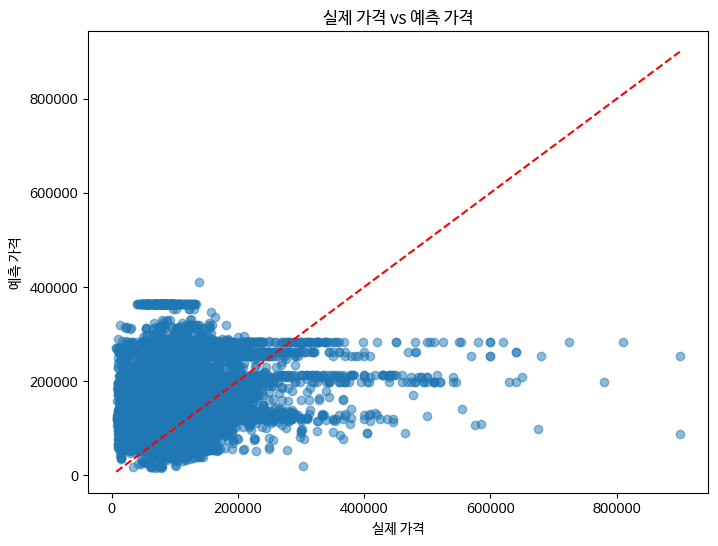

In [118]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.title('실제 가격 vs 예측 가격')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # 대각선 표시
plt.show()

In [68]:
# # LSTM 모델 정의 함수
# def create_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(50, activation='relu', input_shape=input_shape))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # '계약날짜'로 정렬
# df = train
# df = df.sort_values(by=['구', '계약날짜'])

# # 각 구별로 데이터 그룹화
# for name, group in df.groupby('구'):
#     print(f'Processing {name} data...')

#     # 필요한 데이터 사용하여 LSTM 학습
#     features_numeric = ['전용면적', '기준금리', '가격변화율']  # 수치형 변수
#     features_categorical = ['동']  # 범주형 변수

#     # 수치형 변수만 따로 추출
#     X_numeric = group[features_numeric]

#     # 범주형 변수를 OneHotEncoder로 인코딩
#     encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
#     X_categorical = encoder.fit_transform(group[features_categorical]) 
    
#     # 수치형 변수 정규화 (MinMaxScaler 사용)
#     scaler = MinMaxScaler()
#     X_numeric_scaled = scaler.fit_transform(X_numeric)

#     # 원핫 인코딩된 범주형 변수와 정규화된 수치형 변수를 병합
#     X_train = np.hstack([X_numeric_scaled, X_categorical])
    
#     # 이후 시계열 데이터를 window_size로 만들어 LSTM 모델에 입력
#     window_size = 3  # LSTM을 위한 시계열 길이
#     X_lstm_train, y_lstm_train = [], []
#     for i in range(window_size, len(X_train)):
#         X_lstm_train.append(X_train[i-window_size:i])  # window_size 만큼의 데이터를 X로 사용
#         y_lstm_train.append(X_numeric_scaled[i, -1])  # 마지막 열인 '가격변화율'을 y로 사용

#     X_lstm_train = np.array(X_lstm_train)
#     y_lstm_train = np.array(y_lstm_train)

#     # LSTM 입력 형태로 변환 (samples, timesteps, features)
#     X_lstm_train = np.reshape(X_lstm_train, (X_lstm_train.shape[0], X_lstm_train.shape[1], X_train.shape[1]))

#     # LSTM 모델 생성
#     model = create_lstm_model((X_lstm_train.shape[1], X_lstm_train.shape[2]))

#     # 모델 훈련
#     model.fit(X_lstm_train, y_lstm_train, epochs=2, batch_size=1)

#     # # 예측 결과 역정규화
#     # predictions = scaler.inverse_transform(predictions)
#     # y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#     # # RMSE 계산
#     # rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    
#     # # 결과 출력
#     # print(f'{name} 구 RMSE: {rmse}')
#     # print(f'{name} 구 테스트 실제 값: {y_test_actual.flatten()}')
#     # print(f'{name} 구 테스트 예측 값: {predictions.flatten()}')

# # 모델 및 스케일러 저장
# with open(f'./data/lstm_selected_model1.pkl', 'wb') as f:
#     pickle.dump(model, f)
    
# with open(f'./data/lstm_selected_scaler1.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

# with open(f'./data/lstm_selected_encoder1.pkl', 'wb') as f:
#     pickle.dump(encoder, f)



Processing 강남구 data...
Epoch 1/2
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 53s 771us/step - loss: 0.0013
Epoch 2/2
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 52s 758us/step - loss: 1.9787e-04
Processing 강동구 data...
Epoch 1/2
61196/61196 ━━━━━━━━━━━━━━━━━━━━ 47s 754us/step - loss: 0.0018
Epoch 2/2
61196/61196 ━━━━━━━━━━━━━━━━━━━━ 46s 752us/step - loss: 2.7020e-04
Processing 강북구 data...
Epoch 1/2
21690/21690 ━━━━━━━━━━━━━━━━━━━━ 17s 750us/step - loss: 0.0017
Epoch 2/2
21690/21690 ━━━━━━━━━━━━━━━━━━━━ 16s 747us/step - loss: 4.5455e-04
Processing 강서구 data...
Epoch 1/2
66047/66047 ━━━━━━━━━━━━━━━━━━━━ 50s 754us/step - loss: 0.0014
Epoch 2/2
66047/66047 ━━━━━━━━━━━━━━━━━━━━ 50s 757us/step - loss: 2.0645e-04
Processing 관악구 data...
Epoch 1/2
35635/35635 ━━━━━━━━━━━━━━━━━━━━ 27s 749us/step - loss: 0.0016
Epoch 2/2
35635/35635 ━━━━━━━━━━━━━━━━━━━━ 27s 761us/step - loss: 2.7724e-04
Processing 광진구 data...
Epoch 1/2
21866/21866 ━━━━━━━━━━━━━━━━━━━━ 17s 744us/step - loss: 0.0046
Epoch 2/2
21866/21866 ━━━━━━━━━━━━━━━━━

In [69]:
# 모델 및 스케일러 불러오기
with open(f'./data/lstm_selected_model1.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open(f'./data/lstm_selected_scaler1.pkl', 'rb') as f:
    scaler = pickle.load(f)

# with open(f'./data/lstm_selected_encoder1.pkl', 'rb') as f:
#     encoder = pickle.load(f)

In [60]:
print(scaler.feature_names_in_)  # 학습 시 사용된 피처 이름 확인

['전용면적' '기준금리' '가격변화율']


In [62]:
test.columns

Index(['전용면적', '주소', '구', '동', '계약날짜', 'is_test', '기준금리', '제곱미터당가격', '월별평균가',
       '가격변화율', '이전거래가격', '이전거래일', '거래월차이', '예측_가격변동율'],
      dtype='object')

In [70]:
# test 데이터에 대해 예측 수행
df_test = test

# 필요한 데이터 사용하여 LSTM 예측 (train과 동일한 전처리)
features_numeric = ['전용면적', '기준금리']  # 가격변화율은 예측해야 하는 값이므로 제외
features_categorical = ['동']  # 범주형 변수

# 수치형 변수만 따로 추출
X_numeric_test = df_test[features_numeric]

# 범주형 변수를 OneHotEncoder로 인코딩 (train에서 fit한 encoder 사용)
X_categorical_test = encoder.transform(df_test[features_categorical])

# 수치형 변수 정규화 (train에서 fit한 scaler 사용)
X_numeric_scaled_test = scaler.transform(X_numeric_test)

# 원핫 인코딩된 범주형 변수와 정규화된 수치형 변수를 병합
X_test = np.hstack([X_numeric_scaled_test, X_categorical_test])

# 테스트 데이터도 시계열 형태로 변환 (window_size 적용)
X_lstm_test = []
for i in range(window_size, len(X_test)):
    X_lstm_test.append(X_test[i-window_size:i])

X_lstm_test = np.array(X_lstm_test)

# LSTM 입력 형태로 변환 (samples, timesteps, features)
X_lstm_test = np.reshape(X_lstm_test, (X_lstm_test.shape[0], X_lstm_test.shape[1], X_test.shape[1]))

# 학습된 LSTM 모델로 예측 수행
predictions = model.predict(X_lstm_test)

# 예측 결과 역정규화 (필요시, 가격변화율에 해당하는 스케일링을 해제)
predictions = scaler.inverse_transform(predictions)  # 예측된 값을 원래 스케일로 변환

# 결과 출력
print(f'예측된 가격변화율: {predictions.flatten()}')


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 가격변화율


In [50]:
# # 사용할 피처 정의 (학습 시 사용한 피처들만)
# features = ['가격변화율']

# # test1 데이터를 '구'별로 예측하기 위한 절차
# for name, group in test.groupby('구'):
#     print(f'Predicting for {name} 구 with test1 data...')

#     # 해당 구의 모델과 스케일러 가져오기 (train 데이터에서 학습된 모델 사용)
#     model = model  # 저장된 모델
#     scaler = scaler  # 저장된 스케일러

#     # 학습 때 사용된 피처들만 선택 (features 리스트 사용)
#     test1_features = group[features]  # 학습 시 사용한 피처들만 선택

#     # test1 데이터 정규화 (train에서 사용한 scaler 사용)
#     scaled_test1_data = scaler.transform(test1_features)

#     # test1 데이터를 LSTM 입력 형태로 변환
#     X_test1 = []  # 리스트로 선언
#     window_size = 3  # train에서 사용한 window_size와 동일하게 설정
#     for i in range(window_size, len(scaled_test1_data)):
#         X_test1.append(scaled_test1_data[i-window_size:i])  # 피처들만 사용

#     X_test1 = np.array(X_test1)
#     X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], len(features)))  # features에 맞게 변환

#     # 모델을 사용하여 test1 데이터 예측
#     predictions_test1 = model.predict(X_test1)

#     # 예측 결과 역정규화
#     predictions_test1 = scaler.inverse_transform(predictions_test1)

#     # 결과 출력
#     print(f'{name} 구 test1 데이터 예측 결과: {predictions_test1.flatten()}')

#     # 필요 시 test1 데이터프레임에 예측값을 저장
#     test.loc[group.index[window_size:], '예측_가격변동율'] = predictions_test1.flatten()

    


Predicting for 강남구 구 with test1 data...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
강남구 구 test1 데이터 예측 결과: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan

In [47]:
# featurestouse = ['계약날짜', '구', '전용면적', '기준금리', '동', '가격변화율']
# # test1 데이터를 '구'별로 예측하고, 예측된 '가격변동율'로 '월별평균가'를 계산
# for name, group in test.groupby('구'):
#     print(f'Predicting for {name} 구 with test1 data...')

#     # test1 데이터 정규화 (train에서 사용한 scaler 사용)
#     scaled_test1_data = scaler.transform(group[featurestouse])

#     # LSTM 모델 입력 데이터를 생성
#     X_test1 = []
#     window_size = 3  # train에서 사용한 window_size와 동일하게 설정
#     for i in range(window_size, len(scaled_test1_data)):
#         X_test1.append(scaled_test1_data[i-window_size:i, 0])

#     X_test1 = np.array(X_test1)
#     X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

#     # 모델을 사용하여 test1 데이터 예측
#     predictions_test1 = model.predict(X_test1)

#     # 예측 결과 역정규화
#     predictions_test1 = scaler.inverse_transform(predictions_test1)

#     # 예측 결과를 test1에 저장
#     test.loc[group.index[window_size:], '예측_가격변동율'] = predictions_test1.flatten()

# # # 테스트 데이터의 첫 번째 달의 '월별평균가'를 설정
# # test['월별평균가'].iloc[0] = train['월별평균가'].iloc[-1]  # 학습 데이터의 마지막 월별평균가를 초기값으로 설정

# # # 월별평균가 계산을 위한 루프
# # for i in range(1, len(test)):
# #     # 이전 달의 '월별평균가'에 예측된 '가격변동율'을 곱하여 새로운 월별평균가를 계산
# #     test['월별평균가'].iloc[i] = test['월별평균가'].iloc[i-1] * (1 + test['예측_가격변동율'].iloc[i])

# # 결과 확인
# print(test[['계약날짜', '예측_가격변동율', '월별평균가']])


Predicting for 강남구 구 with test1 data...


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 계약날짜
- 구
- 기준금리
- 동
- 전용면적


In [34]:
# # 가정: test1 데이터가 있고 'target' 컬럼에 실제값 또는 임의의 값이 포함되어 있다고 가정
# # test1 데이터를 '구'별로 예측하기 위한 절차
# test = test

# for name, group in test.groupby('구'):
#     print(f'Predicting for {name} 구 with test1 data...')

#     # 해당 구의 모델과 스케일러 가져오기 (train 데이터에서 학습된 모델 사용)
#     model = model
#     scaler = scaler

#     # test1 데이터 정규화 (train에서 사용한 scaler 사용)
#     scaled_test1_data = scaler.transform(group[features])

#     # test1 데이터를 LSTM 입력 형태로 변환
#     X_test = []
#     window_size = 3  # train에서 사용한 window_size와 동일하게 설정
#     for i in range(window_size, len(scaled_test1_data)):
#         X_test1.append(scaled_test1_data[i-window_size:i, 0])

#     X_test1 = np.array(X_test1)
#     X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

#     # 모델을 사용하여 test1 데이터 예측
#     predictions_test1 = model.predict(X_test)

#     # 예측 결과 역정규화
#     predictions_test1 = scaler.inverse_transform(predictions_test1)

#     # 결과 출력
#     print(f'{name} 구 test1 데이터 예측 결과: {predictions_test1.flatten()}')

#     # 필요 시 test1 데이터프레임에 예측값을 저장
#     test.loc[group.index[window_size:], '예측_가격변동율'] = predictions_test1.flatten()


Predicting for 0 구 with test1 data...


ValueError: Expected 2D array, got 1D array instead:
array=[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
test

In [ ]:
# 계약 날짜로 데이터 정렬
test = test.sort_values(by=['구', '계약날짜'])

# 이전 거래가 채우기 및 거래금액 계산
for i in range(1, len(test)):
    if pd.isnull(test.loc[i, '이전거래가']):
        # 이전 거래금액을 현재 거래의 '이전거래가'로 설정
        test.loc[i, '이전거래가'] = test.loc[i-1, 'target']

    # target 누적 곱 계산: 개월수만큼의 이전 target을 모두 곱함
    start_index = max(0, i - test.loc[i, '개월수차이'])  # 개월수차이만큼 이전 데이터 인덱스 계산
    target_cumulative = np.prod(1 + test.loc[start_index:i-1, '가격변동율'])  # 이전 target들의 누적 곱
    
    # 거래금액 계산: 이전거래가 * 누적 target 곱
    test.loc[i, '제곱미터당가격'] = test.loc[i, '이전거래가'] * target_cumulative

In [ ]:
str_columns = ['본번', '부번', '거래취소여부', '구', '동', '강남여부', '신축여부']

concat[str_columns] = concat[str_columns].astype(str)

# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

In [ ]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

print(concat.isnull().sum())         # 결측치가 보간된 모습을 확인해봅니다.
print(concat.shape)

In [ ]:
# test와 train 분리
df = concat.query('is_test == 0')  
df_test = concat.query('is_test == 1')  

# 전용면적 375 이상인 것들은 제거
df= df[df['전용면적'] < 375]

# 층 음수 처리
df['층'] = df['층'].apply(lambda x: 1 if x < 0 else x)
df_test['층'] = df_test['층'].apply(lambda x: 1 if x < 0 else x)

# 건축년도 1965년도 이후에 지어진것만 처리
df= df[df['건축년도'] > 1965]

# 거래일 건물 연식 음수 처리
df= df[df['거래일건물연식'] > 0]
concat_select = pd.concat([df, df_test])
concat_select.info()       # 최종 데이터셋은 아래와 같습니다.

In [ ]:
from math import radians, sin, cos, sqrt, atan2

# 하버사인 공식으로 두 지리적 좌표 간의 거리를 계산하는 함수
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371  # 지구 반경 (킬로미터)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance
subway_path = pd.read_csv('/Users/minseok/Downloads/xgboost/data/subway_feature.csv')
bus_path = pd.read_csv('/Users/minseok/Downloads/xgboost/data/bus_feature.csv')
# concat_select 좌표와 subway_path 좌표를 numpy 배열로 변환
concat_coords = np.array([concat_select['x'], concat_select['y']]).T
subway_coords = np.array([subway_path['경도'], subway_path['위도']]).T
bus_coords = np.array([bus_path['X좌표'], bus_path['Y좌표']]).T
# 빈 리스트를 만들어서 최단 거리를 저장할 것임
shortest_distances_subway = []
shortest_distances_bus = []
# 벡터 연산을 사용하여 가장 가까운 지하철 거리 찾기
for i, concat_coord in tqdm(enumerate(concat_coords), total=len(concat_coords)):
    distances = haversine_np(concat_coord[0], concat_coord[1], subway_coords[:, 0], subway_coords[:, 1])
    min_distance = np.min(distances)
    shortest_distances_subway.append(min_distance)
# 벡터 연산을 사용하여 가장 가까운 버스 거리 찾기
for i, concat_coord in tqdm(enumerate(concat_coords), total=len(concat_coords)):
    distances = haversine_np(concat_coord[0], concat_coord[1], bus_coords[:, 0], bus_coords[:, 1])
    min_distance = np.min(distances)
    shortest_distances_bus.append(min_distance)
# concat_select에 최단 거리를 추가
concat_select['지하철최단거리'] = shortest_distances_subway
concat_select['버스최단거리'] = shortest_distances_bus
concat_select['버스최단거리'].describe()

#거리별 가중치 부여
concat_select['지하철최단거리'] = concat_select['지하철최단거리'].apply(lambda x: 3 if 0 < x < 0.3 else (2 if 0.3 < x < 0.65 else(1 if 0.65<x<1.0 else 0) ))
concat_select['버스최단거리'] = concat_select['버스최단거리'].apply(lambda x: 2 if 0 < x < 0.5 else (1 if 0.5 < x < 1 else 0))


#10분 이내로 

In [ ]:
brand_patterns = {
   #1군 하이엔트
   '디에이치':3, '푸르지오써밋': 3, '르엘':3,'오티에르':3, '아크로':3,
   #1군
   '힐스테이트': 2, '푸르지오':2, '롯데캐슬':2, '더샵':2, 'e-편한세상':2,'래미안':2 , '아이파크':2, '자이':2,
   #2군 하이엔드
   '위브더제니스':2,'호반써밋':2,
    #2군
    '위브': 1,'우미린':1,'한화포레나':1, '서희스타힐스':1,'더플래티넘':1, '한라비발디':1,'호반베르디움':1, '데시앙':1, '센트레빌':1,'SKVIEW':1,''
    '하늘채': 1,'스위첸':1
}
# 특정 문자열을 포함하는 경우에 따라 값을 반환하는 함수 정의
def assign_brand_value(apartment_name):
    for pattern, value in brand_patterns.items():
        if pattern in apartment_name:
            return value
    return 0
# '아파트브랜드이름'이라는 새로운 열 생성
concat_select['아파트브랜드이름'] = concat_select['아파트명'].apply(assign_brand_value)
print(concat_select.shape, concat_select.columns)

In [99]:
# # 금리 데이터 로드 및 처리
# interest = pd.read_csv('/Users/minseok/Downloads/xgboost/data/한국기준금리07-23.csv')

# interest['계약년월'] = interest['날짜'].astype(str).str[:6]

# interest_grouped = interest.groupby('계약년월').agg({'기준금리': 'mean'}).reset_index()

# concat_select['계약년월'] = concat_select['계약년'].astype(str) + concat_select['계약월'].astype(str)

# concat_select = pd.merge(concat_select, interest_grouped, on='계약년월', how='left')



# print(concat_select.shape, concat_select.columns)

In [100]:
# concat_select = concat_select.drop(columns=['계약년월'])
# print(concat_select.shape, concat_select.columns)

In [ ]:
school_path = pd.read_csv('/Users/minseok/Downloads/xgboost/data/청주대학교_지방교육재정연구원_초중등학교위치_20240322.csv', encoding='EUC-KR')
h_school = school_path[school_path['학교급구분'] == '고등학교']
m_school = school_path[school_path['학교급구분'] == '중학교']
p_school = school_path[school_path['학교급구분'] == '초등학교']
h_school_coords = np.array([h_school['경도'], h_school['위도']]).T
m_school_coords = np.array([m_school['경도'], m_school['위도']]).T
p_school_coords = np.array([p_school['경도'], p_school['위도']]).T
# 빈 리스트를 만들어서 최단 거리를 저장할 것임
shortest_distances_h_school = []
shortest_distances_m_school = []
shortest_distances_p_school = []
for i, concat_coord in tqdm(enumerate(concat_coords), total=len(concat_coords)):
    distances = haversine_np(concat_coord[0], concat_coord[1], h_school_coords[:, 0], h_school_coords[:, 1])
    min_distance1 = np.min(distances)
    shortest_distances_h_school.append(min_distance1)
for i, concat_coord in tqdm(enumerate(concat_coords), total=len(concat_coords)):
    distances = haversine_np(concat_coord[0], concat_coord[1], m_school_coords[:, 0], m_school_coords[:, 1])
    min_distance2 = np.min(distances)
    shortest_distances_m_school.append(min_distance2)
for i, concat_coord in tqdm(enumerate(concat_coords), total=len(concat_coords)):
    distances = haversine_np(concat_coord[0], concat_coord[1], p_school_coords[:, 0], p_school_coords[:, 1])
    min_distance3 = np.min(distances)
    shortest_distances_p_school.append(min_distance3)
concat_select['고등학교최단거리'] = shortest_distances_h_school
concat_select['중등학교최단거리'] = shortest_distances_m_school
concat_select['초등학교최단거리'] = shortest_distances_p_school
concat_select['초등학교최단거리'] = concat_select['초등학교최단거리'].apply(lambda x: 3 if 0 < x < 0.5 else (2 if 0.5 < x < 1.0 else(1 if 1.0<x<1.5 else 0) ))
concat_select['중등학교최단거리'] = concat_select['중등학교최단거리'].apply(lambda x: 3 if 0 < x < 0.5 else (2 if 0.5 < x < 1.0 else(1 if 1.0<x<1.5 else 0) ))
concat_select['고등학교최단거리'] = concat_select['고등학교최단거리'].apply(lambda x: 3 if 0 < x < 0.5 else (2 if 0.5 < x < 1.0 else(1 if 1.0<x<1.5 else 0) ))
concat_select.head()

In [95]:
# str_columns = ['초등학교최단거리', '중등학교최단거리', '고등학교최단거리']

# concat_select[str_columns] = concat_select[str_columns].astype(str)

# print(concat_select.shape)

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 결과 출력
print(dt_train.shape, dt_test.shape)

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [ ]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

In [103]:
dt_train = pd.get_dummies(dt_train, columns=['구'])
dt_test = pd.get_dummies(dt_test, columns=['구'])

In [104]:
columns_to_delete = ['번지', '부번', '본번']

# # 열 삭제
dt_train = dt_train.drop(columns=columns_to_delete)
dt_test = dt_test.drop(columns=columns_to_delete)

In [105]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [ ]:
# #  XGBoost 사용

# import xgboost as xgb

# model = xgb.XGBRegressor(objective='reg:squarederror', 
#                          n_estimators=2000,  
#                          learning_rate=0.1,  
#                          max_depth=10,
#                          random_state=1)

# model.fit(X_train, y_train)

# pred_2 = model.predict(X_val)

# # 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
# print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred_2))}')

In [69]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import joblib
import os

# RMSE 계산 함수
def RMSE(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [9000, 10000, 11000, 12000],  # 더 높은 n_estimators 설정
    'learning_rate': [0.05, 0.075, 0.1],  # 학습률을 더 세밀하게 설정
    'max_depth': [5, 6, 7],  # max_depth 범위를 확장하여 조정
    'min_child_weight': [1, 3],  # 현재 최적값 유지
    'subsample': [0.8],  # 그대로 유지
    'colsample_bytree': [0.8],  # 그대로 유지
    'gamma': [0],  # 그대로 유지
    'lambda': [1],  # 그대로 유지
    'alpha': [0]  # 그대로 유지
}

# 체크포인트 경로 설정
checkpoint_path = "grid_search_checkpoint.pkl"

# 체크포인트에서 학습 재개
if os.path.exists(checkpoint_path):
    start_idx, best_params, best_rmse = joblib.load(checkpoint_path)
    print(f"Checkpoint 로드 완료, {start_idx}번째 파라미터부터 재개.")
else:
    start_idx = 0
    best_params = None
    best_rmse = float('inf')
    print("새로운 학습 시작.")

# XGBRegressor 모델 정의
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=2024
)

# 파라미터 그리드 순회
for idx, params in enumerate(ParameterGrid(param_grid)):
    if idx < start_idx:
        continue  # 이전에 완료된 파라미터 조합은 건너뜀
    
    # 모델 학습
    print(f"{idx + 1}번째 파라미터 조합 학습 중: {params}")
    xgb_model.set_params(**params)
    xgb_model.fit(X_train, y_train)

    # 검증 세트에서 예측
    pred_val = xgb_model.predict(X_val)
    val_rmse = RMSE(y_val, pred_val)
    print(f"Validation RMSE: {val_rmse:.4f}")

    # 최적 파라미터 갱신
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_params = params

    # 진행 상황을 체크포인트에 저장
    joblib.dump((idx + 1, best_params, best_rmse), checkpoint_path)
    print(f"Checkpoint 저장됨: {checkpoint_path}")

# 최적 파라미터 및 성능 출력
print(f"최적 파라미터: {best_params}, Best RMSE: {best_rmse:.4f}")

# 최적 모델로 학습 후 모델 저장
best_xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=2024)
best_xgb_model.fit(X_train, y_train)
best_xgb_model.save_model(f"xgb_best_model_rmse_{best_rmse:.4f}.model")

# 체크포인트 삭제
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print("Checkpoint 파일 삭제 완료.")

In [ ]:
from sklearn import metrics

# 예측 수행
pred_2 = best_xgb_model.predict(X_val)

# RMSE 계산
rmse_result = np.sqrt(metrics.mean_squared_error(y_val, pred_2))

# 결과 출력 및 파일 저장
print(f'RMSE test: {rmse_result}')

# 결과를 파일에 저장
with open("rmse_result.txt", "w") as f:
    f.write(f'RMSE test: {rmse_result}\n')
    f.write(f"최적 파라미터: {best_params}, Best RMSE: {best_rmse:.4f}")

In [ ]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

In [ ]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
X_test = dt_test.drop(['target'], axis=1)

real_test_pred = model.predict(X_test)

In [ ]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)